In [347]:
import pandas as pd
import numpy as np
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nltk
from nltk import bigrams, trigrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
import advertools as adv
from PIL import Image
from wordcloud import WordCloud
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from afinn import Afinn
from textblob import TextBlob

First, we need to parse the data correctly 

In [200]:
# read csv file
text = pd.read_csv('sa.csv').loc[:,["Caption","Date"]]

#create correct mapping for german months to english months
german_to_english_months = {
    'Jan': 'Jan', 'Feb': 'Feb', 'Mär': 'Mar', 'Apr': 'Apr', 'Mai': 'May', 'Jun': 'Jun',
    'Jul': 'Jul', 'Aug': 'Aug', 'Sep': 'Sep', 'Okt': 'Oct', 'Nov': 'Nov', 'Dez': 'Dec'
}

# Replace German months with English months
text['Date'] = text['Date'].replace(german_to_english_months, regex=True)

#Parse the date
text['Date'] = pd.to_datetime(text['Date'], format='%b %d, %Y, %H:%M:%S', errors='coerce')

Now, the actual preprocessing can start.

We will tokenize the words using avdertools, handle hashtags separately and also specify n-grams for later use.
Furthermore, we want to keep the temporal element intact by creating dataframes that keeps the dates of the different posts intact.

We will also to lemmatization for this rule-based analysis for obvious reasons. 

In [201]:
# setting up the env
# during tokenization, remove custom stopwords and any other stopwords

nltk.download("stopwords")

nltk.download("punkt")

nltk.download("wordnet")

nltk.download("omw-1.4")

stop_words = set(stopwords.words("english"))


# Add custom stopwords

custom_stopwords = {
    "shop",
    "item",
    "now",
    "tag",
    "someone",
    "style",
    "winners",
    "fashion",
    "http",
    "https",
    "u",
    "search",
    "link",
    "featured",
    "tap",
    "shipping",
    "dress",
    "bio",
    "bikini",
    "top",
    "shirt",
    "skirt",
    "look",
    "blouse"
}  # Add any domain-specific stopwords

stop_words.update(custom_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LaptopBraun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LaptopBraun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LaptopBraun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\LaptopBraun\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [202]:
# comprehensive lists of all words and hashtags
word_list = [
    hashtag
    for i in range(len(text))
    for hashtag in adv.extract_hashtags(text["Caption"][i])["hashtags"][0]
]

# Function to filter, tokenize, and lemmatize the text
def process_text(text, stop_words = stop_words ,lemmatize=True, no_gram=True):
    if no_gram:
        words = [
            word
            for word in word_tokenize(text.lower())
            if word.isalpha()
            and word not in stop_words
            and not word.startswith("shein")
            and not word.startswith("#")
            and len(word) > 2
        ]
    else:
        words = [word for word in word_tokenize(text.lower()) if word.isalpha()]
        
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        processed_words = [lemmatizer.lemmatize(word) for word in words]
    else:
        stemmer = PorterStemmer()
        processed_words = [stemmer.stem(word) for word in words]
    return processed_words


# Generate lemmatized unigrams, bigrams, and trigrams as raw lists
word_list_unigram = [
    word for i in range(len(text)) for word in process_text(text["Caption"][i])
]


word_list_bigram = [
    " ".join(bg)
    for i in range(len(text))
    for bg in bigrams(process_text(text["Caption"][i], no_gram=False))
    if all(
        word not in stop_words
        and not word.startswith("shein")
        and not word.startswith("#")
        for word in bg
    )
]

word_list_trigram = [
    " ".join(tg)
    for i in range(len(text))
    for tg in trigrams(process_text(text["Caption"][i], no_gram=False))
    if all(
        word not in stop_words
        and not word.startswith("shein")
        and not word.startswith("#")
        for word in tg
    )
]

In [203]:
# now for the dataframe
lemmatizer = WordNetLemmatizer()


# Function to filter, tokenize, and lemmatize the text, then create n-grams
def process_caption(caption):
    words = [
        word
        for word in word_tokenize(caption.lower())
        if word.isalpha()
        and word not in stop_words
        and not word.startswith("shein")
        and not word.startswith("#")
    ]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    unigrams = lemmatized_words
    bigrams_list = [
        " ".join(bg)
        for bg in bigrams(lemmatized_words)
        if all(
            word not in stop_words
            and not word.startswith("shein")
            and not word.startswith("#")
            and len(word) > 2
            for word in bg
        )
    ]
    trigrams_list = [
        " ".join(tg)
        for tg in trigrams(lemmatized_words)
        if all(
            word not in stop_words
            and not word.startswith("shein")
            and not word.startswith("#")
            and len(word) > 2
            for word in tg
        )
    ]
    return unigrams, bigrams_list, trigrams_list


# Apply function to each caption and store the results in separate lists
unigrams_list = []
bigrams_list = []
trigrams_list = []
hashtag_list = []

for caption in text["Caption"]:
    uni, bi, tri = process_caption(caption)
    unigrams_list.append(uni)
    bigrams_list.append(bi)
    trigrams_list.append(tri)
    hashtag_list.append(adv.extract_hashtags(caption)["hashtags"][0])

df_ngrams = pd.DataFrame(
    {
        "Unigrams": unigrams_list,
        "Bigrams": bigrams_list,
        "Trigrams": trigrams_list,
        "Hashtags": hashtag_list,
        "Date": text["Date"],
    }
)

EDA
Let's explore our data before taking any more preprocessing steps
1. We will generate some wordclouds to get a general sense of the topics and tonality of the shein-posts and hashtags and potentially update the stopwords if needed.
2. We will look at the lengths of the posts to see whether (especially the unigram column in out dataframe) to see if our preprocessing was too strict
3. We will create a connectivity graph to examine the relationships between our n-gram word combinations

New stopwords were added iteratively after creating several wordclouds

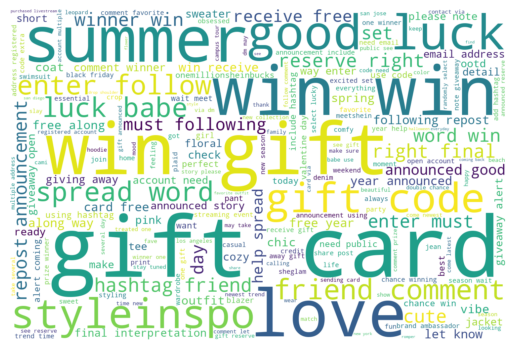

<Figure size 2000x1000 with 0 Axes>

[('win', 1046), ('gift', 767), ('comment', 504), ('card', 488), ('enter', 439), ('like', 434), ('announced', 432), ('day', 428), ('giveaway', 391), ('get', 374), ('new', 363), ('year', 359), ('outfit', 357), ('friend', 355), ('post', 353), ('summer', 346), ('free', 338), ('good', 329), ('code', 327), ('babe', 317), ('follow', 306), ('love', 304), ('collection', 296), ('favorite', 296), ('see', 290), ('set', 289), ('one', 282), ('repost', 278), ('winner', 273), ('cute', 272), ('hashtag', 271), ('come', 270), ('ready', 268), ('prize', 265), ('receive', 252), ('time', 241), ('meet', 232), ('season', 226), ('need', 220), ('chance', 219), ('luck', 218), ('share', 212), ('let', 212), ('coming', 208), ('way', 205), ('fall', 203), ('story', 195), ('must', 194), ('spread', 193), ('make', 191), ('word', 191), ('right', 188), ('want', 184), ('styleinspo', 183), ('know', 178), ('lucky', 177), ('spring', 173), ('account', 170), ('take', 167), ('vibe', 166), ('sweater', 161), ('help', 160), ('follow

In [204]:
def makeImage_uni(str_list):

    wc = WordCloud(width=1500, height=1000, background_color="white", max_words=200)
    # generate word cloud
    wc.generate(str_list)
   
    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.figure( figsize=(20,10) )
    plt.show()
    
makeImage_uni(' '.join(word_list_unigram))

def count_words(str_list):

    # Count the number of occurrences of each string
    string_count = Counter(str_list)

    # Order the count of strings by number of occurrences
    ordered_counts = string_count.most_common()

    # Display the ordered counts
    print(ordered_counts)

count_words(word_list_unigram)

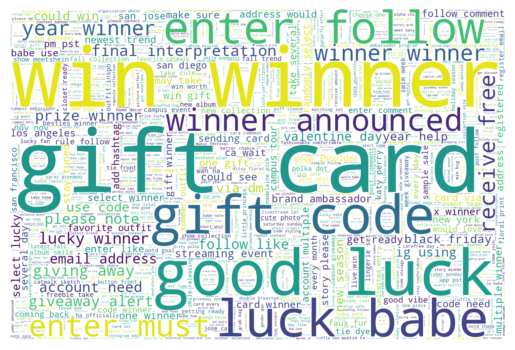

<Figure size 2000x1000 with 0 Axes>

[('gift card', 437), ('win winner', 409), ('good luck', 217), ('gift code', 179), ('luck babe', 166), ('enter follow', 164), ('winner announced', 146), ('enter must', 136), ('winner winner', 133), ('receive free', 129), ('year winner', 114), ('final interpretation', 112), ('lucky winner', 110), ('giving away', 106), ('giveaway alert', 100), ('prize winner', 98), ('please note', 95), ('account need', 89), ('email address', 86), ('follow like', 84), ('via dm', 77), ('use code', 76), ('ig using', 73), ('valentine day', 69), ('could win', 66), ('new season', 63), ('black friday', 62), ('year help', 61), ('select lucky', 58), ('streaming event', 52), ('could see', 49), ('one winner', 46), ('get ready', 46), ('brand ambassador', 46), ('one gift', 45), ('address registered', 42), ('account multiple', 42), ('multiple winner', 42), ('address would', 42), ('select winner', 42), ('ca wait', 41), ('san jose', 41), ('babe use', 41), ('randomly select', 40), ('win gift', 39), ('sending card', 39), (

In [206]:
#interesting, lets first plot n-grams before discarding of more stopwords
def makeImage_n(text):

    ngram_counts = Counter(text)
    wc = WordCloud(width=1500, height=1000, background_color="white", max_words=1000)
    # generate word cloud
    wc.generate_from_frequencies(ngram_counts)
   
    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.figure( figsize=(20,10) )
    plt.show()
    
makeImage_n(word_list_bigram)

count_words(word_list_bigram)

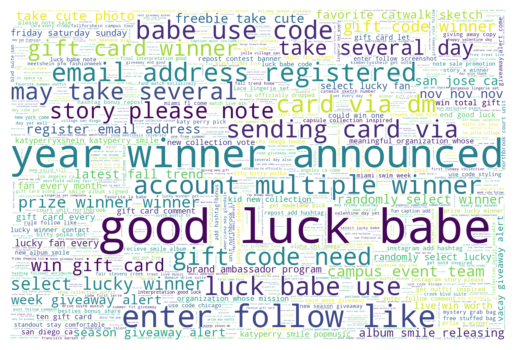

<Figure size 2000x1000 with 0 Axes>

[('good luck babe', 165), ('year winner announced', 114), ('enter follow like', 65), ('email address registered', 42), ('account multiple winner', 42), ('luck babe use', 41), ('babe use code', 41), ('sending card via', 39), ('card via dm', 39), ('gift code need', 38), ('may take several', 37), ('story please note', 36), ('gift card winner', 36), ('take several day', 32), ('select lucky winner', 30), ('win gift card', 30), ('prize winner winner', 27), ('gift code winner', 26), ('campus event team', 25), ('register email address', 23), ('take cute photo', 23), ('week giveaway alert', 23), ('freebie take cute', 22), ('randomly select winner', 21), ('nov nov nov', 21), ('latest fall trend', 21), ('san jose ca', 21), ('season giveaway alert', 20), ('favorite catwalk sketch', 20), ('album smile releasing', 19), ('brand ambassador program', 19), ('randomly select lucky', 19), ('live win worth', 19), ('select lucky fan', 19), ('lucky fan every', 19), ('fan every month', 19), ('gift card every'

In [207]:
makeImage_n(word_list_trigram)

count_words(word_list_trigram)

In [208]:
#Lets look at the length of the captions
Caption_length = text["Caption"].apply(len)
Caption_length.describe() #looks fine

count    6456.000000
mean      199.217007
std       189.488251
min        12.000000
25%       122.000000
50%       143.000000
75%       170.000000
max      1516.000000
Name: Caption, dtype: float64

Before discarding of all the giveaway related content, we should create connectivity graphs.
It seems there are a lot of typical phrases here that should not be taken out of context for the rule based analysis

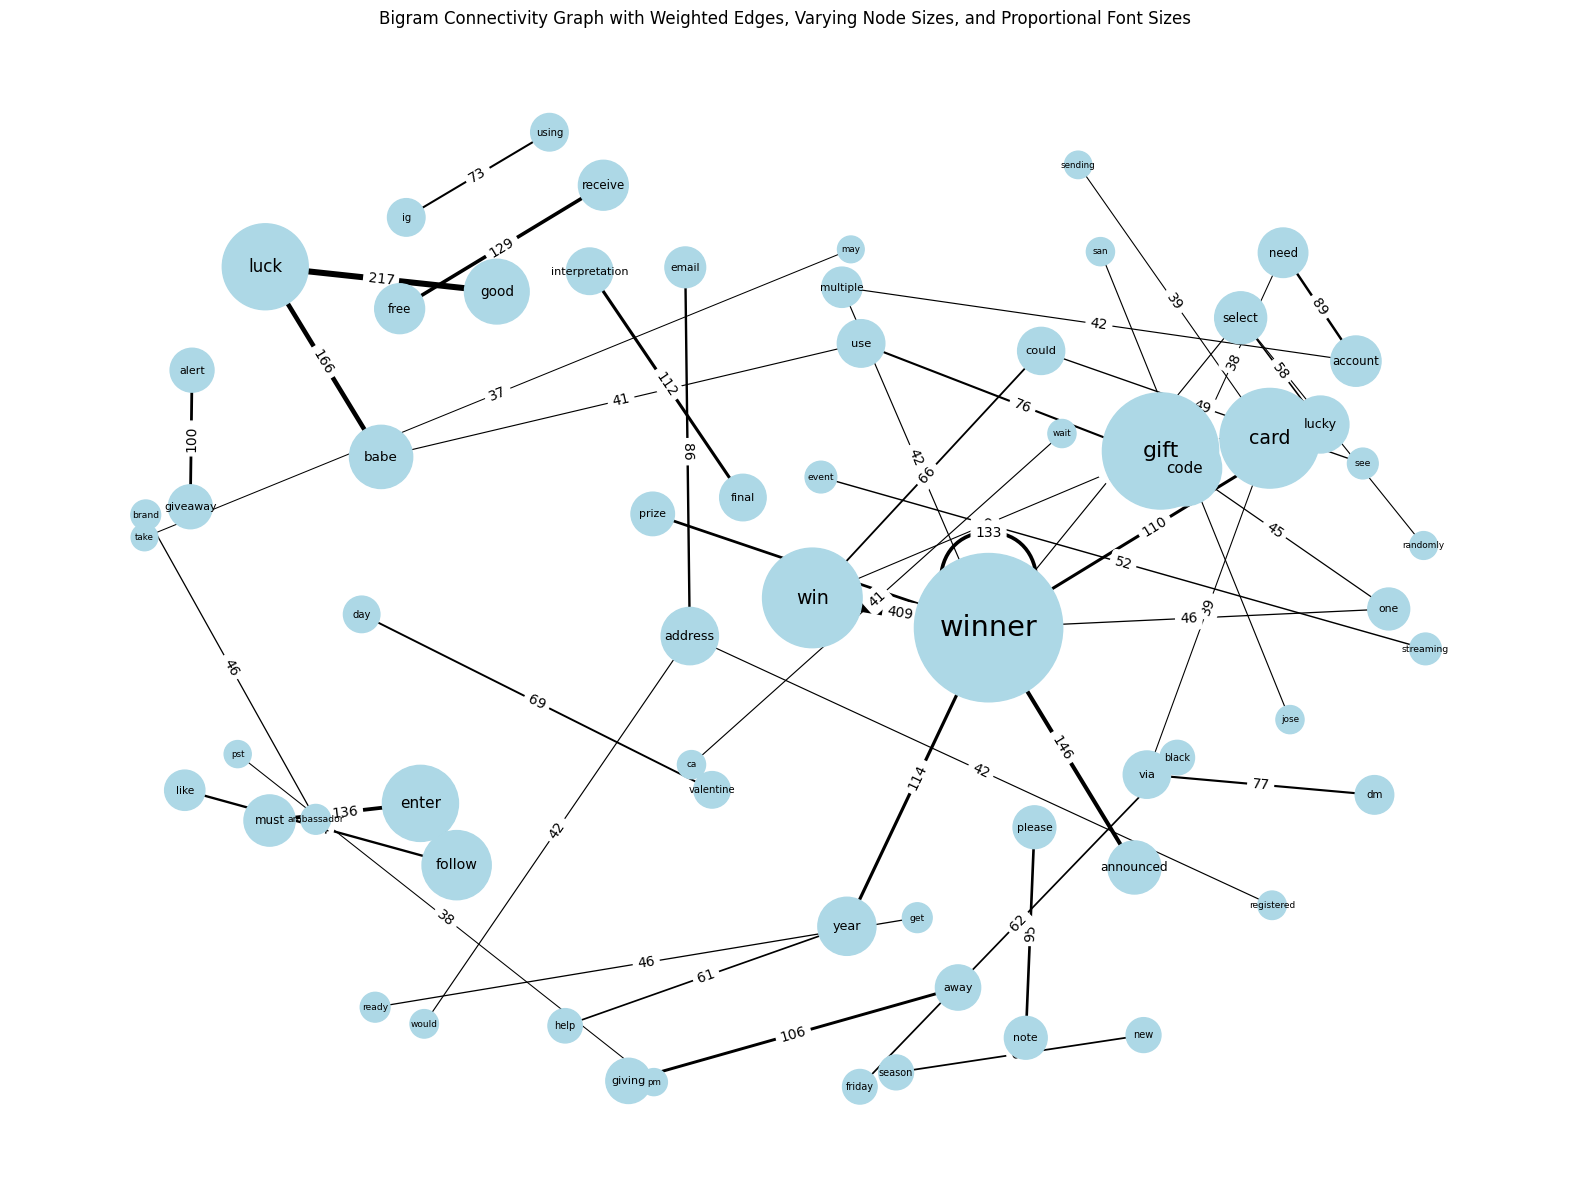

In [322]:
# Create a graph
G = nx.Graph()

bigram_tuples = [tuple(bigram.split()) for bigram in word_list_bigram]

# Count frequencies of each bigram tuple
bigram_counts = Counter(bigram_tuples).most_common(50)
# Adding edges from the data
for (word1, word2), weight in bigram_counts:
    G.add_edge(word1, word2, weight=weight)

plt.figure(figsize=(20, 15))
# Position nodes using the spring layout
pos = nx.spring_layout(G, seed=42, k = 3)

# Calculate node sizes based on the sum of edge weights (scaled for visibility)
node_sizes = [sum(data['weight'] for _, _, data in G.edges(node, data=True)) for node in G.nodes()]
scaled_node_sizes = [size / 0.1 for size in node_sizes]  # Adjust size scale as needed

# Draw the nodes with increased size
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=scaled_node_sizes)

# Draw the edges with varying width based on the weight
edge_widths = [G[u][v]['weight'] / 50 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_widths)

# Create a font size list based on node sizes (simple linear scaling)
font_sizes = [np.log(size)+0.05*size / 50 for size in scaled_node_sizes]  # Scale font size in relation to node size

# Draw labels for nodes with varying font sizes
for node, font_size in zip(G.nodes(), font_sizes):
    nx.draw_networkx_labels(G, pos, labels={node: node}, font_size=font_size)

# Edge labels with weights
edge_labels = {(u, v): f'{d["weight"]}' for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.title("Bigram Connectivity Graph with Weighted Edges, Varying Node Sizes, and Proportional Font Sizes")
plt.axis('off')  # Turn off the axis
plt.show()

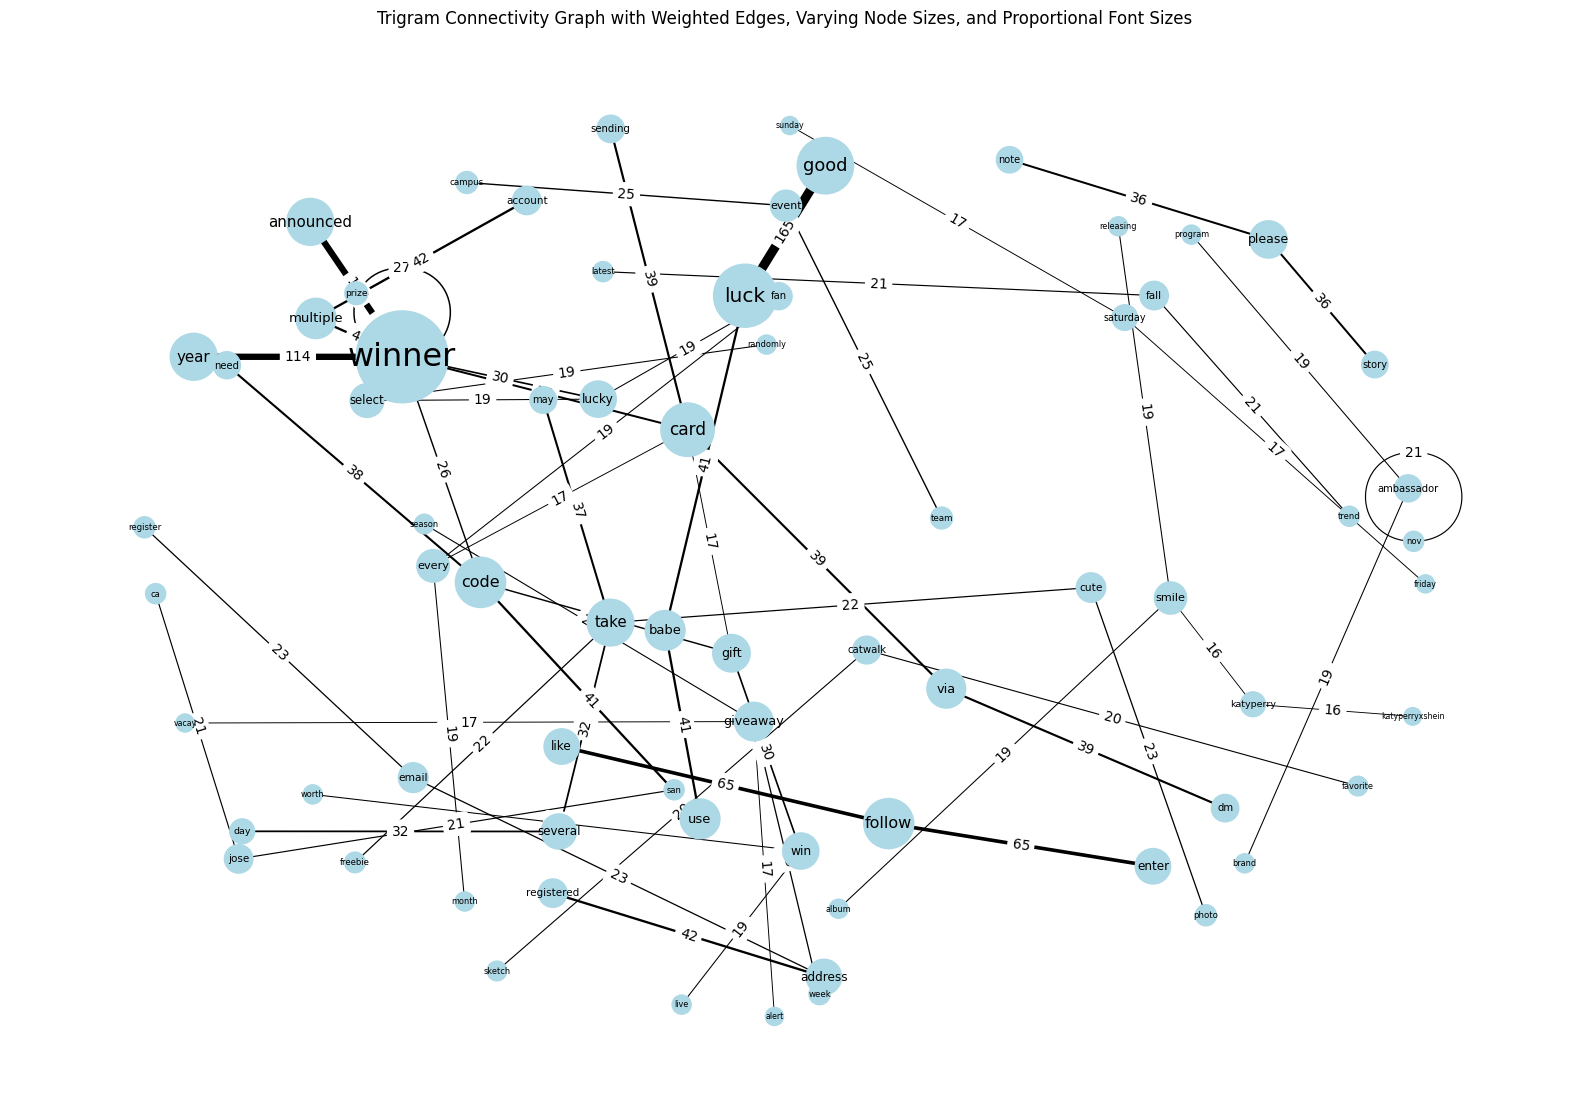

In [323]:
# Create a graph
G = nx.Graph()

trigram_tuples = [tuple(gram.split()) for gram in word_list_trigram]

# Count frequencies of each bigram tuple
trigram_counts = Counter(trigram_tuples).most_common(40)
# Adding edges from the data
for (word1, word2, word3), weight in trigram_counts:
    G.add_edge(word1, word2, weight=weight)
    G.add_edge(word2, word3, weight=weight)

plt.figure(figsize=(20, 14))
# Position nodes using the spring layout
pos = nx.spring_layout(G, seed=42, k=2)

# Calculate node sizes based on the sum of edge weights (scaled for visibility)
node_sizes = [sum(data['weight'] for _, _, data in G.edges(node, data=True)) for node in G.nodes()]
scaled_node_sizes = [size / 0.1 for size in node_sizes]  # Adjust size scale as needed

# Draw the nodes with increased size
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=scaled_node_sizes)

# Draw the edges with varying width based on the weight
edge_widths = [G[u][v]['weight'] / 25 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_widths)

# Create a font size list based on node sizes (simple linear scaling)
font_sizes = [np.log(size) + 0.1 * size / 30 for size in scaled_node_sizes]  # Scale font size in relation to node size

# Draw labels for nodes with varying font sizes
for node, font_size in zip(G.nodes(), font_sizes):
    nx.draw_networkx_labels(G, pos, labels={node: node}, font_size=font_size)

# Edge labels with weights
edge_labels = {(u, v): f'{d["weight"]}' for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.title("Trigram Connectivity Graph with Weighted Edges, Varying Node Sizes, and Proportional Font Sizes")
plt.axis('off')  # Turn off the axis
plt.show()

Lets run the sentiment analysis before removing giveaway related words, as these are extremely frequent  

In [224]:
#lets first do an overall sentiment analysis

#using AFINN
afinn = Afinn()

# Perform sentiment analysis
sentiment_score = afinn.score(" ".join(word_list_unigram))

# Determine sentiment based on the score
if sentiment_score > 0:
    sentiment = "Positive"
elif sentiment_score == 0:
    sentiment = "Neutral"
else:
    sentiment = "Negative"

# Print results
print("Average Sentiment Score:", sentiment_score/ len(word_list_unigram))
print("Sentiment:", sentiment)

Average Sentiment Score: 0.36939785537530934
Sentiment: Positive


In [229]:
#using nrc
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Perform sentiment analysis
sentiment_score = sid.polarity_scores(" ".join(word_list_unigram))
print()
# Print results
print("Sentiment Score:", sentiment_score)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LaptopBraun\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



Sentiment Score: {'neg': 0.021, 'neu': 0.558, 'pos': 0.421, 'compound': 1.0}


In [230]:
#using bing
blob = TextBlob(" ".join(word_list_unigram))

# Perform sentiment analysis using Bing lexicon
sentiment_score = blob.sentiment.polarity

# Determine sentiment based on the score
if sentiment_score > 0:
    sentiment = "Positive"
elif sentiment_score == 0:
    sentiment = "Neutral"
else:
    sentiment = "Negative"

# Print results
print("Sentiment Score:", sentiment_score)
print("Sentiment:", sentiment)

Text: This is a very good movie. I enjoyed it a lot!
Sentiment Score: 0.29314573894242363
Sentiment: Positive


Generally positive tonality. Let's dive deeper

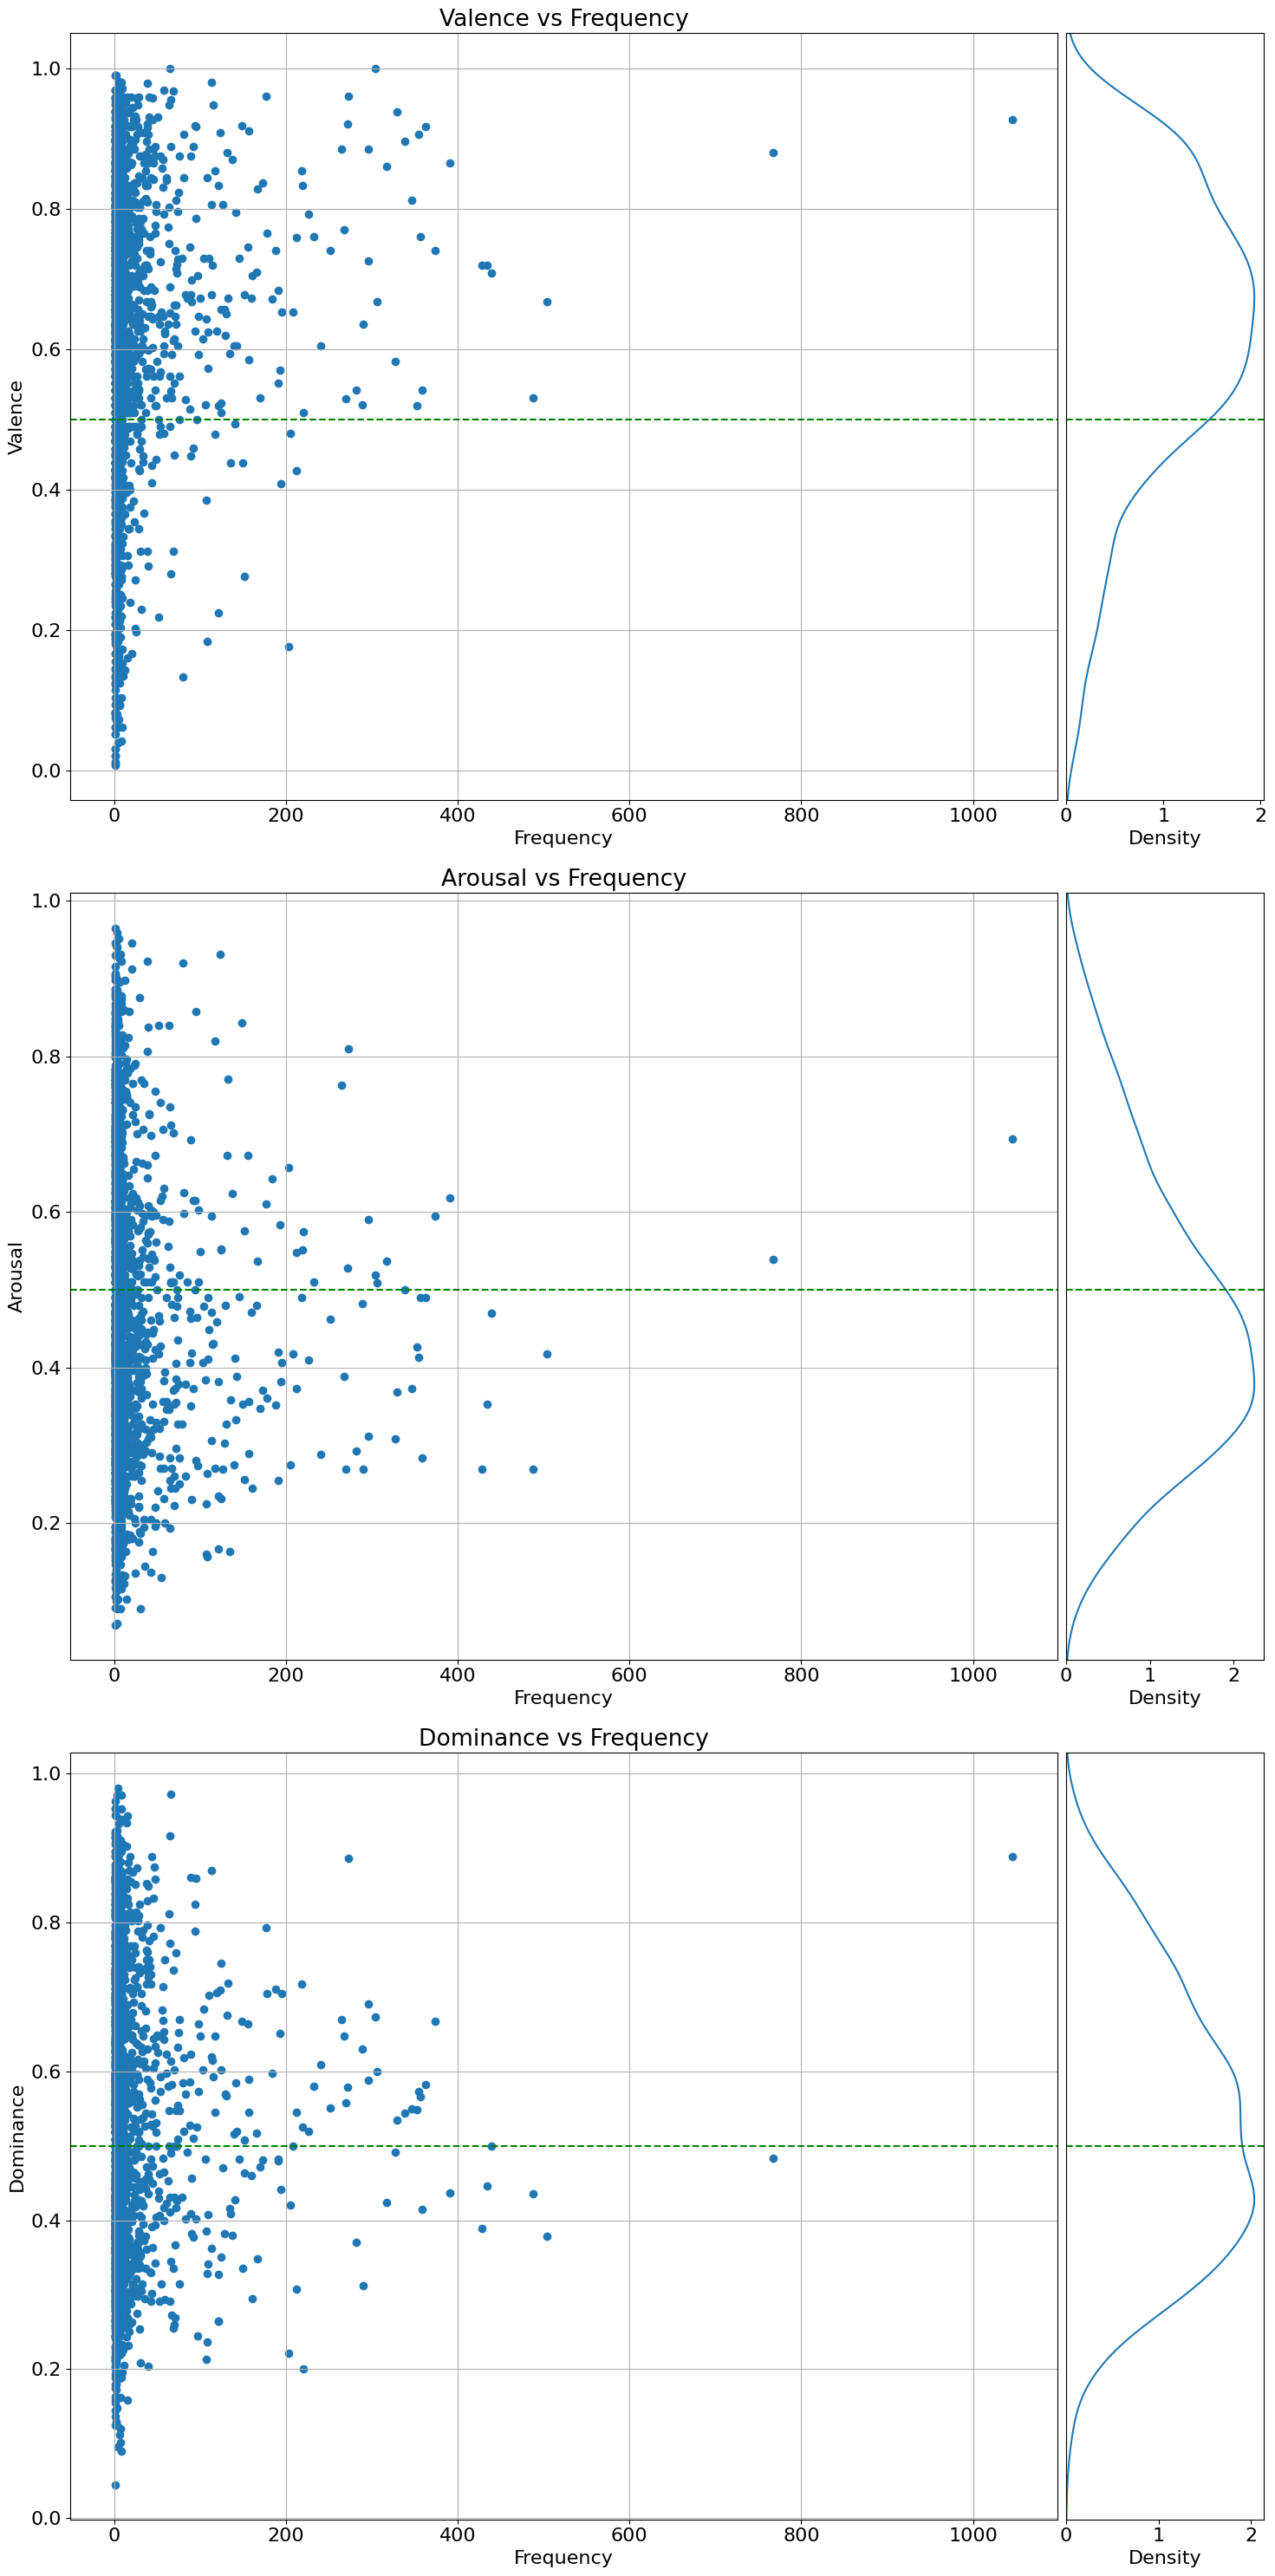

In [350]:
#now for a more detailed analysis with Valence Arousal Dominance Lexicon
# Load NRC Emotion Lexicon

def load_vad_lexicon(file_path):
    lexicon = defaultdict(dict)
    with open(file_path, 'r') as file:
        for line in file:
            word, valence, arousal, dominance = line.strip().split('\t')
            lexicon[word] = {'valence': float(valence), 'arousal': float(arousal), 'dominance': float(dominance)}
    return lexicon

lexicon = load_vad_lexicon('VAD.txt')

# Initialize emotional dimensions
emotional_dimensions = defaultdict(lambda: {'valence': 0, 'arousal': 0, 'dominance': 0, 'frequency': 0})

#classify tokens based on lexicon
for token in word_list_unigram:
    if token in lexicon:
        # Update emotional dimensions based on lexicon
        emotional_dimensions[token]['valence'] = lexicon[token]['valence']
        emotional_dimensions[token]['arousal'] = lexicon[token]['arousal']
        emotional_dimensions[token]['dominance'] = lexicon[token]['dominance']
        # Increment frequency count for this token
        emotional_dimensions[token]['frequency'] += 1
# Sort emotional dimensions by frequency and select the top 300

emotional_dimensions_most_frequent = dict(sorted(emotional_dimensions.items(), key=lambda x: x[1]['frequency'], reverse=True)[:300])
# Create subplots
mpl.rcParams.update({'font.size': 16}) 
fig, axes = plt.subplots(3, 1, figsize=(15, 30))

# Titles for the plots
titles = ['Valence vs Frequency', 'Arousal vs Frequency', 'Dominance vs Frequency']

# Emotional dimensions to plot
dimensions = ['valence', 'arousal', 'dominance']

# Plot each dimension
for i, dimension in enumerate(dimensions):
    ax = axes[i]
    x = [emotional_dimensions[token]['frequency'] for token in emotional_dimensions]
    y = [emotional_dimensions[token][dimension] for token in emotional_dimensions]

    # Scatter plot on the original axis
    ax.scatter(x, y)
    ax.set_xlabel('Frequency')
    ax.set_ylabel(dimension.capitalize())
    ax.set_title(titles[i])
    ax.grid(True)
    ax.axhline(y=0.5, color='green', linestyle='--', label='Y = 0.5')
    # Create a new axis on the right for the KDE plot
    divider = make_axes_locatable(ax)
    ax_density = divider.append_axes("right", size="20%", pad=0.1)
    
    # Create a density plot (KDE) on the new axis
    sns.kdeplot(y=y, ax=ax_density)
    ax_density.set_xlabel('Density')
    ax_density.set_ylim(ax.get_ylim())  # Align y-limits with the scatter plot
    ax_density.yaxis.set_visible(False)  # Hide y-axis labels to reduce clutter
    ax_density.axhline(y=0.5, color='green', linestyle='--', label='Y = 0.5')
# Layout adjustment and show plot
plt.tight_layout()
plt.show()

Interesting distributions! High Valence, low Arousal. Laid back, good mood, easy life, fuck the environment, save a couple bucks...nice!
Gotta love that!

C:\Users\LaptopBraun\AppData\Local\Temp\ipykernel_13592\1960154116.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label=dim)


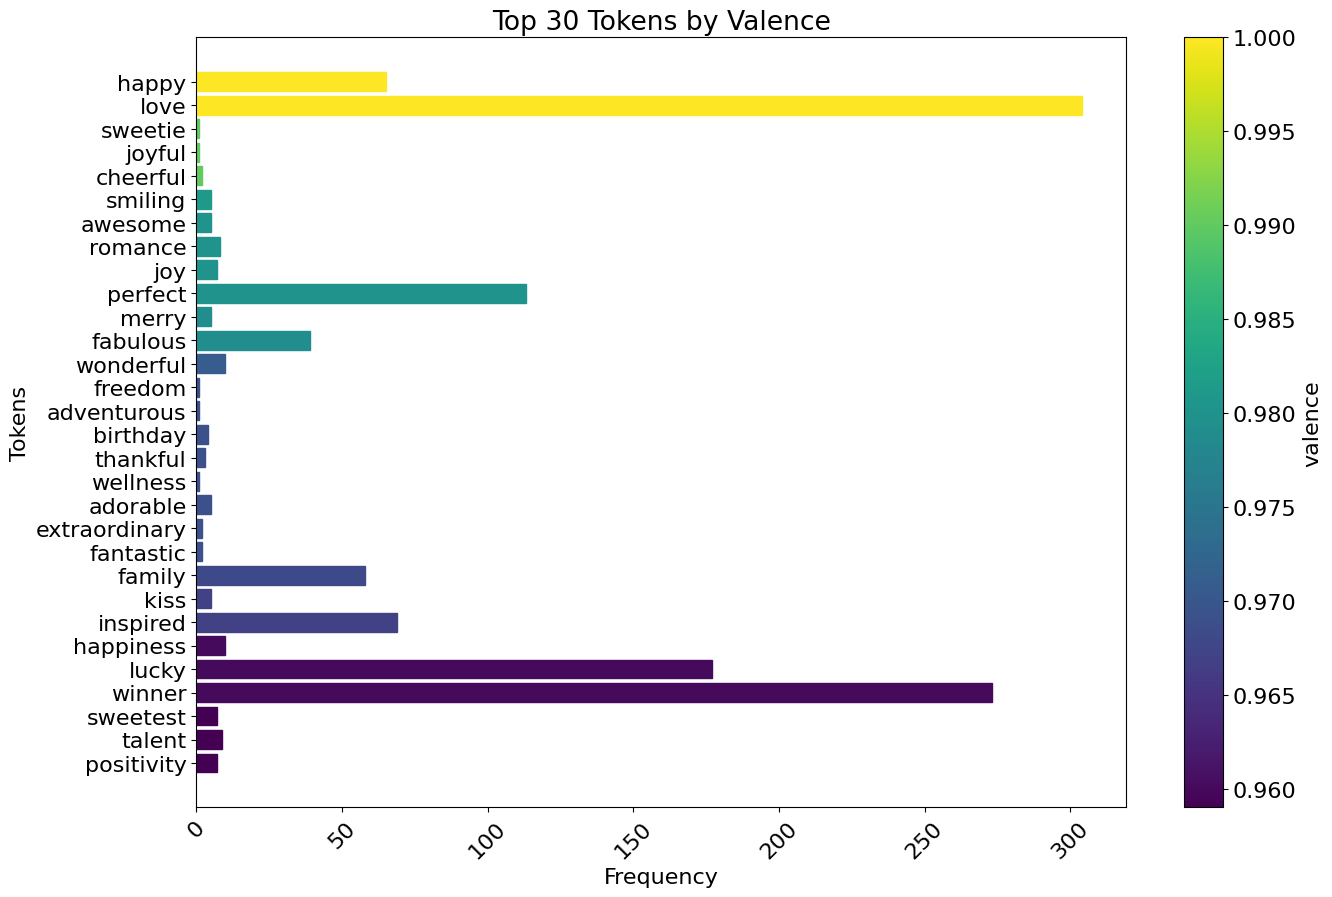

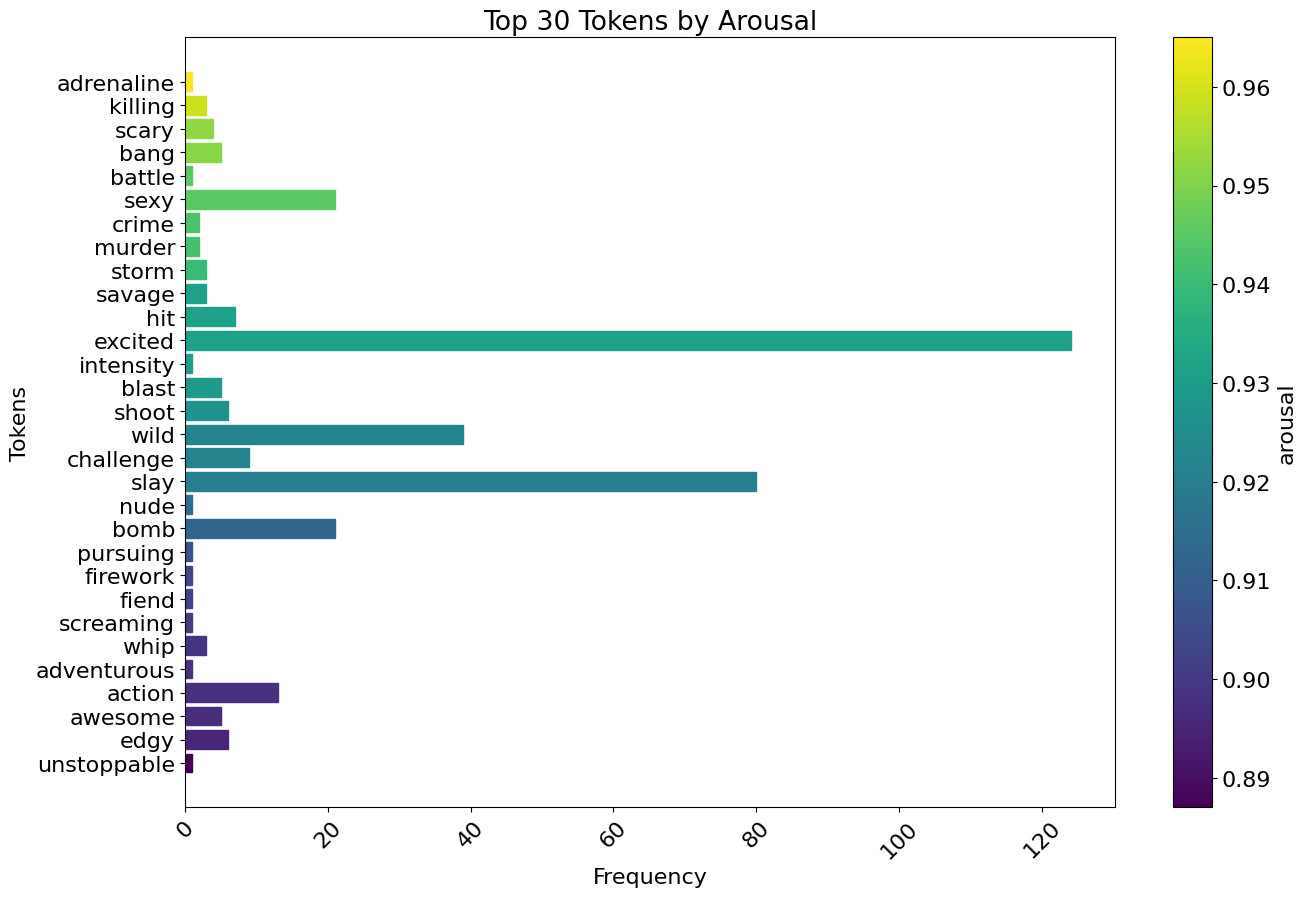

In [364]:
# Sorting the tokens by valence and arousal
top_valence = sorted(emotional_dimensions.items(), key=lambda x: x[1]['valence'], reverse=True)[:30]
top_arousal = sorted(emotional_dimensions.items(), key=lambda x: x[1]['arousal'], reverse=True)[:30]

# Sorting the top 20 tokens again by valence for the bar order
top_valence_sorted = sorted(top_valence, key=lambda x: x[1]['valence'])
top_arousal_sorted = sorted(top_arousal, key=lambda x: x[1]['arousal'])
# Function to plot the data
def plot_top_tokens(data, title, dim):
    tokens = [x[0] for x in data]
    frequencies = [x[1]['frequency'] for x in data]
    valences = [x[1][dim] for x in data]
    plt.figure(figsize=(15, 10))
    bars = plt.barh(tokens, frequencies, color='skyblue')
    plt.ylabel('Tokens')
    plt.xlabel('Frequency')
    plt.title(title)
    plt.xticks(rotation=45)
    
    
     # Normalize valence values for coloring
    norm = plt.Normalize(min(valences), max(valences))
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    # Color the bars based on valence scores
    for bar, valence in zip(bars, valences):
        bar.set_color(sm.to_rgba(valence))

    
    plt.colorbar(sm, label=dim)
    
    plt.show()
# Plotting the top 20 tokens by valence
plot_top_tokens(top_valence_sorted, 'Top 30 Tokens by Valence', 'valence')

# Plotting the top 20 tokens by arousal
plot_top_tokens(top_arousal_sorted, 'Top 30 Tokens by Arousal', 'arousal')

C:\Users\LaptopBraun\AppData\Local\Temp\ipykernel_13592\2907564019.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label=dim)


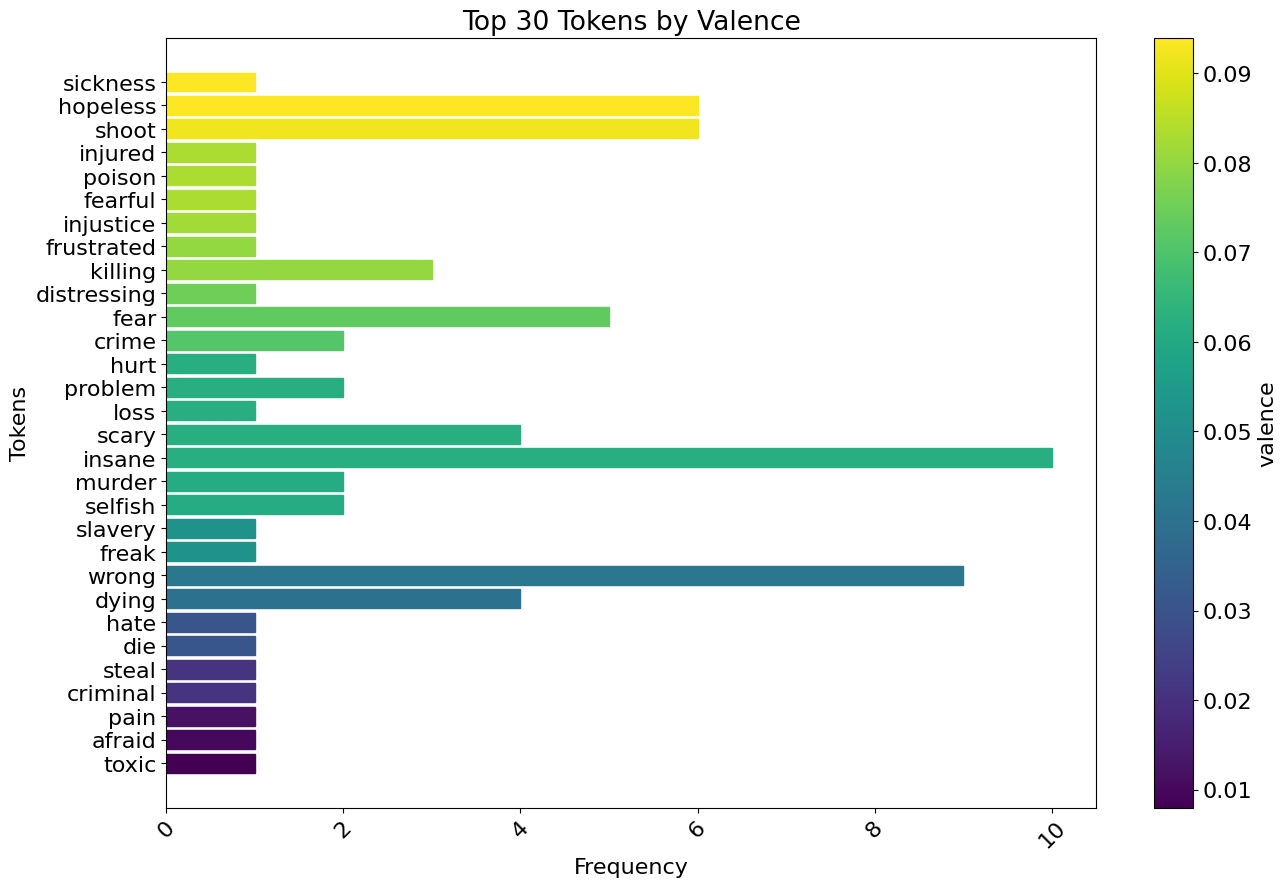

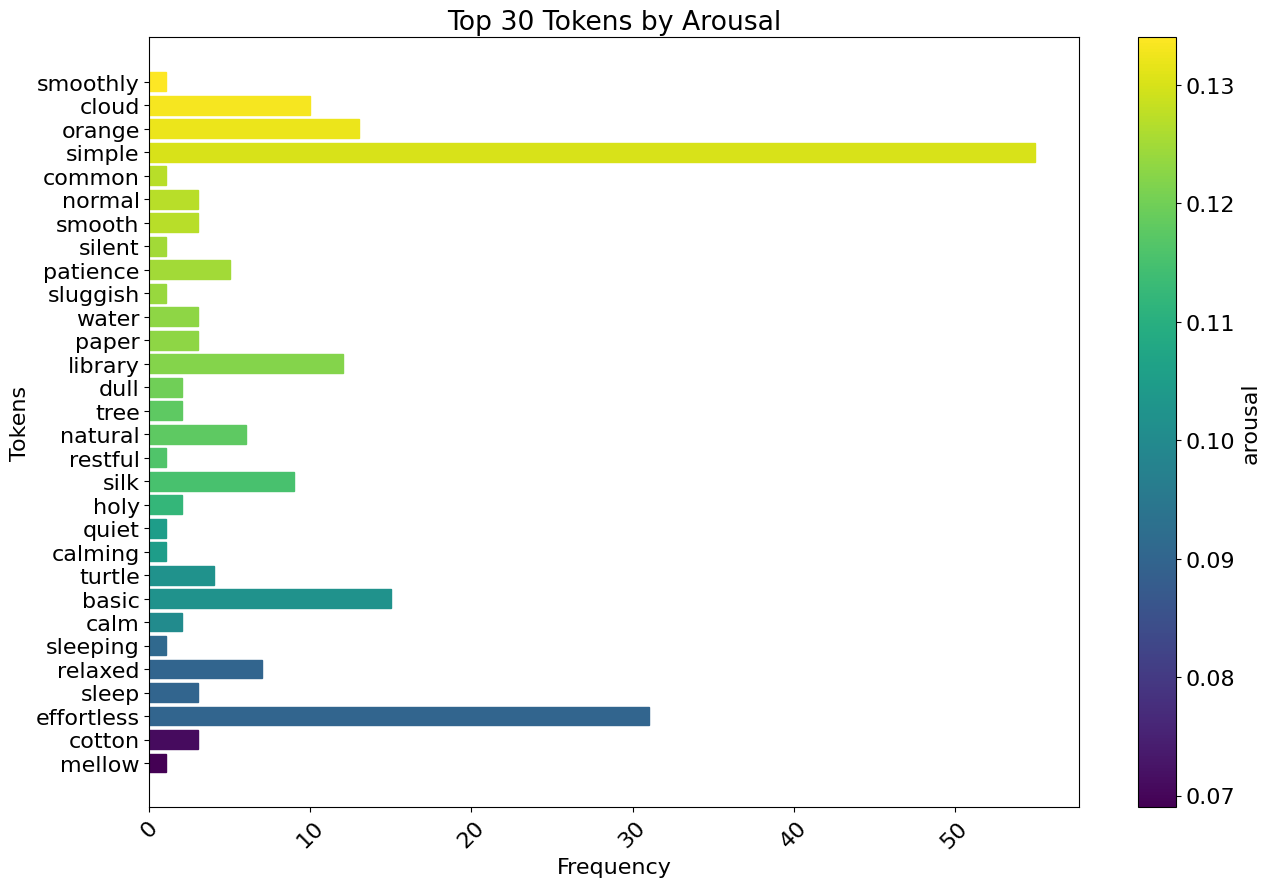

In [365]:
# Sorting the tokens by valence and arousal
top_valence = sorted(emotional_dimensions.items(), key=lambda x: x[1]['valence'])[:30]
top_arousal = sorted(emotional_dimensions.items(), key=lambda x: x[1]['arousal'])[:30]

# Sorting the top 20 tokens again by valence for the bar order
top_valence_sorted = sorted(top_valence, key=lambda x: x[1]['valence'])
top_arousal_sorted = sorted(top_arousal, key=lambda x: x[1]['arousal'])
# Function to plot the data
def plot_top_tokens(data, title, dim):
    tokens = [x[0] for x in data]
    frequencies = [x[1]['frequency'] for x in data]
    valences = [x[1][dim] for x in data]
    plt.figure(figsize=(15, 10))
    bars = plt.barh(tokens, frequencies, color='skyblue')
    plt.ylabel('Tokens')
    plt.xlabel('Frequency')
    plt.title(title)
    plt.xticks(rotation=45)
    
    
     # Normalize valence values for coloring
    norm = plt.Normalize(min(valences), max(valences))
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    # Color the bars based on valence scores
    for bar, valence in zip(bars, valences):
        bar.set_color(sm.to_rgba(valence))

    
    plt.colorbar(sm, label=dim)
    
    plt.show()
# Plotting the top 20 tokens by valence
plot_top_tokens(top_valence_sorted, 'Top 30 Tokens by Valence', 'valence')

# Plotting the top 20 tokens by arousal
plot_top_tokens(top_arousal_sorted, 'Top 30 Tokens by Arousal', 'arousal')